## Происходит считывание данных с файла и их визуализация

In [1]:
# Рисовать графики сразу 
%matplotlib inline 

# необходимые либы 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import time

# Для виджетов 
from IPython.display import display, clear_output
from ipywidgets import DatePicker, Checkbox, ToggleButton, HBox

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

### 1. Считываем данные генерации и потребления за год

In [2]:
# Объединяем колонки INTERVAL иM_DATE
def date_time_parser(d, t): 
    date = dt.datetime.strptime(d, '%d.%m.%Y %H:%M:%S')
    try: 
        hour = int(t)
    except ValueError:
        hour = 0
    finally:
        time = dt.time(hour)
    return dt.datetime.combine(date, time)
    
df = pd.read_csv(
    'data/Генерация и потребление_01.01.2016-28.11.2020.csv',
    sep=';',
    parse_dates={'DATE_TIME':['M_DATE', "INTERVAL"]}, 
    date_parser=date_time_parser,
    )
# Удалим неопределенные? зоны 
# df = df[df['POWER_SYS_ID'] != 0]
del df['PRICE_ZONE_ID']
del df['POWER_SYS_ID']
df

,DATE_TIME,E_USE_FACT
0,2016-01-01 00:00:00,30382.0
1,2016-01-01 01:00:00,29942.0
2,2016-01-01 02:00:00,29658.0
3,2016-01-01 03:00:00,29637.0
4,2016-01-01 04:00:00,29517.0
...,...,...
43051,2020-11-28 19:00:00,0.0
43052,2020-11-28 20:00:00,0.0
43053,2020-11-28 21:00:00,0.0
43054,2020-11-28 22:00:00,0.0


### 2. Фильтрация данных
#### 2.1 Дата

In [3]:
# Определяем от и до 
date_from = dt.datetime(2016, 1, 1, 0, 0)
date_to = dt.datetime(2019, 12, 31, 0, 0)

dpicker_from = DatePicker(
    description='От:',
    value = date_from
)
dpicker_to = DatePicker(
    description='До:',
    value=date_to
)

def time_2_datetime(t):
    return dt.datetime.combine(t, dt.datetime.min.time())

def on_from_button_clicked(b):
    global date_from
    date_from = time_2_datetime(b['new'])

def on_to_button_clicked(b):
    global date_to
    date_to = time_2_datetime(b['new'])

dpicker_from.observe(on_from_button_clicked, names='value')
dpicker_to.observe(on_to_button_clicked, names='value')

HBox([dpicker_from, dpicker_to])


#### 2.2 Ценовая зона

In [4]:
# first_zone = True 
# second_zone = True 

# first_cb = Checkbox(
#     description="1 ценовая зона",
#     value=first_zone)

# second_cb = Checkbox(
#     description="2 ценовая зона",
#     value=second_zone)

# def on_first_clicked(cb):
#     global first_zone
#     first_zone = cb.new
#     print("First zone ", first_zone)
    
# def on_second_clicked(cb): 
#     global second_zone
#     second_zone = cb.new
#     print("Second zone ", second_zone)
    
# first_cb.observe(on_first_clicked, names='value')
# second_cb.observe(on_second_clicked, names='value')

# HBox([first_cb, second_cb])


#### 2.3 Объединенные энергосистемы

In [5]:
# sys_list = df['POWER_SYS_ID'].unique()

# # инициализируем выбранные 
# sys_checked = dict((sys, True) for sys in sys_list)

# # создаём кнопочки 
# sys_cbs = [] 
# for sys in sys_list: 
#     def handler(local_sys): 
#         def wrap(cb):
#             global sys_checked
#             sys_checked[local_sys] = cb.new 
#             print(f"ОЭС {local_sys} {cb.new}")
#         return wrap
    
#     cb = Checkbox(
#         description=str(sys),
#         value = sys_checked[sys],
#         )
#     cb.observe(handler(sys), names='value')
#     sys_cbs.append(cb)
    
# HBox(sys_cbs)

#### 2.4 Выбираем графики 

In [6]:
# Список графиков 
# graphs = ('E_USE_FACT','E_USE_PLAN', 'GEN_FACT', 'GEN_PLAN')
graphs = ('E_USE_FACT',)
# инициализируем выбранные графики 
graph_checked = dict((gr, True) for gr in graphs)

# создаём кнопочки 
graph_cbs = [] 
for graph in graphs: 
    def handler(local_graph): 
        def wrap(cb):
            global graph_checked
            graph_checked[local_graph] = cb.new 
            print(f"График {local_graph} {cb.new}")
        return wrap
    
    cb = Checkbox(
        description=str(graph),
        value = graph_checked[graph],
        )
    cb.observe(handler(graph), names='value')
    graph_cbs.append(cb)
    
HBox(graph_cbs)

### 3. Графики по заданному диапазону

ToggleButton(value=False, description='Show')

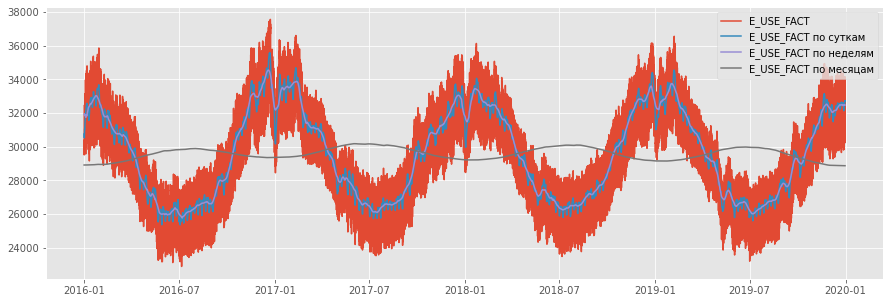

In [7]:
# Сглаживание скользящим средним
def running_mean(y: np.ndarray, window: int) -> np.ndarray:
    yc = np.pad(y, window, mode='symmetric')
    yy = y.copy()
    for wi in range(window, len(y) + window):
        yy[wi - window] = np.nanmean(yc[wi - window: wi + window])

    return yy

# фильтруем по датам 
def filter_by_date(data_frame): 
    global date_from, date_to
    return (date_from <= data_frame['DATE_TIME']) & (data_frame['DATE_TIME'] <= date_to)
    

# # фильтруем по зонам 
# def filter_by_zones(data_frame): 
#     global first_zone, second_zone
    
#     zone_filter = np.zeros(data_frame.shape[0], dtype=bool)
#     for zone_checked, zone_value in [(first_zone, 1), (second_zone, 2)]:
#         if zone_checked:
#             zone_filter |= (data_frame['PRICE_ZONE_ID'] == zone_value)
#     return zone_filter

# # фильтруем по ОЭС
# def filter_by_sys(data_frame):
#     global sys_checked

#     sys_filter = np.zeros(data_frame.shape[0], dtype=bool)
#     for sys, checked in sys_checked.items():
#         if checked: 
#             sys_filter |= (data_frame["POWER_SYS_ID"] == sys)
#     return sys_filter 


tb = ToggleButton(
    value=False,
    description='Show'
    )

def on_show(state):
    global df 
    global graphs, graph_checked
    
    # очищаем экран 
    clear_output(wait=True)
    display(tb)
    # фильтруем данные 
    filtered = df[filter_by_date(df)
#                   & filter_by_zones(df)
#                   & filter_by_sys(df)
                 ]
    
    # выводим на экран
#     for sys_key in filtered['POWER_SYS_ID'].unique():
#         sys_df = filtered[filtered['POWER_SYS_ID'] == sys_key]
    sys_df = filtered
    for power_key in graphs:
        if graph_checked[power_key]:
            plt.plot(sys_df['DATE_TIME'], sys_df[power_key], label='{0}'.format(power_key))
            plt.plot(sys_df['DATE_TIME'], running_mean(sys_df[power_key].values, 24), label='{0} по суткам'.format(power_key))
            plt.plot(sys_df['DATE_TIME'], running_mean(sys_df[power_key].values, 24 * 7), label='{0} по неделям'.format(power_key))
            plt.plot(sys_df['DATE_TIME'], running_mean(sys_df[power_key].values, 24 * 7 * 30), label='{0} по месяцам'.format(power_key))
    plt.legend()
tb.observe(on_show, names='value')
on_show({})

